In [1]:
%matplotlib inline
import os
import copy
import random
import pandas as pd
import numpy as np
import torch
from torch import autograd
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
from torchvision.io import read_image, ImageReadMode
import torchvision.transforms.functional as TF
from torchvision import transforms as T
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.utils import make_grid
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import LabelEncoder

In [2]:
from os import listdir
from pathlib import Path
def load_dir(dir):
    images = []
    masks = []
    label = []
    resize = T.Resize((128,128))
    for subdir in listdir(dir):
        for file in listdir(f"{dir}/{subdir}"):
            if file.endswith(".png") and "mask" not in file:
                image = read_image(f"{dir}/{subdir}/{file}", ImageReadMode.GRAY)
                image = resize(image)
                image = TF.convert_image_dtype(image, dtype=torch.float32)
                
                filename = file.split(".")[0]
                files_list = list(Path(f"{dir}/{subdir}").rglob(f"{filename}*"))
                masks_list = [f for f in files_list if "mask" in str(f)]

                if len(masks_list) == 1:
                        mask_file = masks_list[0]
                        mask = read_image(f"{mask_file}", ImageReadMode.GRAY)
                        mask = resize(mask)
                        mask = TF.convert_image_dtype(mask, dtype=torch.float32)
                        
                        images.append(image)
                        masks.append(mask)
                        label.append(subdir)
                        
                else:
                    continue
                    
    return images, masks, label

In [3]:
class BUSI_dataset(Dataset):
    def __init__(self, path):
        self.images, self.masks, labels = load_dir(path)
        self.transform = T.Compose([
            T.Normalize(0.5, 0.5),
        ])
        
        encLabel = LabelEncoder().fit_transform(labels)
        self.labels = torch.from_numpy(encLabel)
    
    def __getitem__(self, index):
        return self.transform(self.images[index]), self.transform(self.masks[index]), self.labels[index]
    
    def __len__(self):
        return len(self.images)

In [4]:
path = "../input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT"
dataset = BUSI_dataset(path)
dataLoader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=2)

In [5]:
def show_image(images):
    fig, ax = plt.subplots(figsize=(20,20))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid((images.detach()), nrow=8, normalize=True).permute(1, 2, 0))

In [6]:
data = next(iter(dataLoader))
print(data[2], data[2][4])

tensor([1, 0, 0, 0, 2, 0, 0, 1, 1, 0, 0, 2, 1, 1, 0, 0]) tensor(2)


In [7]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [8]:
class GenBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        super(GenBlock, self).__init__()
        
        self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.norm = nn.BatchNorm2d(out_channels)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        #self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        
        return self.relu(x)

class DisBlock(nn.Module):
    def __init__(self, in_channels, out_channels, img_size, kernel_size, stride=1, padding=0):
        super(DisBlock, self).__init__()
        
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.norm = nn.LayerNorm([out_channels, img_size//2, img_size//2])
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        #self.dropout = nn.Dropout(0.5)
    
    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        
        return self.relu(x)

In [9]:
##Generator architecture
class Generator(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels):
        super(Generator, self).__init__()
        
        self.inBlock = GenBlock(in_channels, mid_channels, kernel_size=4, stride=1, padding=0)  #4x4
        self.net = nn.Sequential(
            GenBlock(mid_channels, mid_channels//2, kernel_size=4, stride=2, padding=1),  #8x8
            GenBlock(mid_channels//2, mid_channels//4, kernel_size=4, stride=2, padding=1),  #16x16
            GenBlock(mid_channels//4, mid_channels//8, kernel_size=4, stride=2, padding=1),  #32x32
            GenBlock(mid_channels//8, mid_channels//16, kernel_size=4, stride=2, padding=1),  #64x64
            nn.ConvTranspose2d(mid_channels//16, out_channels, kernel_size=4, stride=2, padding=1),#128x128
            nn.Tanh())
        
        self.embedding = nn.Embedding(3, 50)
        self.linear = nn.Linear(50, 4*4)
        
    def forward(self, x):
        #y = self.embedding(label)
        #y = self.linear(y).view(-1,1,4,4)
        x = self.inBlock(x)
        #x = torch.cat((x,y), dim=1)
        return self.net(x)

In [10]:
## Discriminator architecture
class Discriminator(nn.Module):
    def __init__(self, in_channels, mid_channels):
        super(Discriminator, self).__init__()
        
        self.embedding = nn.Embedding(3, 50)
        self.inLinear = nn.Linear(50, 128*128)
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, 4, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            DisBlock(mid_channels, mid_channels*2, 64, 4, 2, 1),
            DisBlock(mid_channels*2, mid_channels*4, 32, 4, 2, 1),
            DisBlock(mid_channels*4, mid_channels*8, 16, 4, 2, 1),
            DisBlock(mid_channels*8, mid_channels*16, 8, 4, 2, 1),
            nn.Conv2d(mid_channels*16, 1, 4, 1, 0)
        )
    
    def forward(self, x):
        #y = self.embedding(label)
        #y = self.inLinear(y).view(-1,1,128,128)
        #x = torch.cat((x,y), dim=1)
        x = self.net(x)
        return x

In [11]:
class WassersteinLoss(nn.Module):
    def __init__(self):
        super(WassersteinLoss, self).__init__()
    
    def forward(self, inputs, targets):
        loss = torch.mean(inputs * targets)
        return loss

In [12]:
def generate_samples(GNet, device):
    B = 8
    nz = 100
    with torch.no_grad():
        noise = torch.randn(B,nz,1,1,device=device)
        noisyLabel = torch.randint(0, 3, (B,), device=device)
        output = GNet(noise).permute(1,0,2,3).to("cpu")
        images = torch.unsqueeze(output[0],dim=1)
        masks = torch.unsqueeze(output[1],dim=1)
        show_image(images)
        show_image(masks)

In [13]:
def compute_gradient_penalty(D, real_samples, fake_samples, device):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), dtype=torch.float, device=device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates).view(real_samples.size(0), -1)
    fake = torch.full((real_samples.shape[0], 1), 1.0, dtype=torch.float, device=device, requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

Epoch 1/700 : Discriminator real loss: -2308.9023 | Discriminator fake loss: -2405.2903 | Discriminator loss: -96.3879 | Generator loss: 478.0395
Epoch 2/700 : Discriminator real loss: -4090.2285 | Discriminator fake loss: -4174.1528 | Discriminator loss: -83.9243 | Generator loss: 801.2097
Epoch 3/700 : Discriminator real loss: -5133.1133 | Discriminator fake loss: -5152.6113 | Discriminator loss: -19.4980 | Generator loss: 968.9752
Epoch 4/700 : Discriminator real loss: -5911.5112 | Discriminator fake loss: -5927.7285 | Discriminator loss: -16.2173 | Generator loss: 1159.5852
Epoch 5/700 : Discriminator real loss: -6587.0908 | Discriminator fake loss: -6599.4463 | Discriminator loss: -12.3555 | Generator loss: 1238.6582
Epoch 6/700 : Discriminator real loss: -6893.6528 | Discriminator fake loss: -6550.2485 | Discriminator loss: 343.4043 | Generator loss: 1258.1528
Epoch 7/700 : Discriminator real loss: -7057.9893 | Discriminator fake loss: -5736.2744 | Discriminator loss: 1321.7148 |

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Epoch 551/700 : Discriminator real loss: -267.0401 | Discriminator fake loss: -2000.7543 | Discriminator loss: -1733.7141 | Generator loss: 447.3942
Epoch 552/700 : Discriminator real loss: -260.6330 | Discriminator fake loss: -2035.3018 | Discriminator loss: -1774.6688 | Generator loss: 429.6245
Epoch 553/700 : Discriminator real loss: -261.4685 | Discriminator fake loss: -2011.3873 | Discriminator loss: -1749.9188 | Generator loss: 452.7683
Epoch 554/700 : Discriminator real loss: -350.6762 | Discriminator fake loss: -2032.6531 | Discriminator loss: -1681.9769 | Generator loss: 471.4305
Epoch 555/700 : Discriminator real loss: -206.7076 | Discriminator fake loss: -2093.2024 | Discriminator loss: -1886.4948 | Generator loss: 487.6428
Epoch 556/700 : Discriminator real loss: -23.4641 | Discriminator fake loss: -2232.6218 | Discriminator loss: -2209.1577 | Generator loss: 486.6113
Epoch 557/700 : Discriminator real loss: 169.4221 | Discriminator fake loss: -2443.7004 | Discriminator los

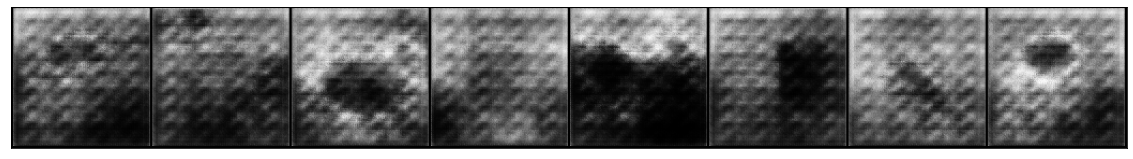

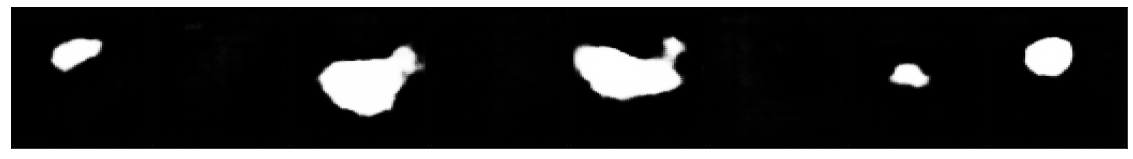

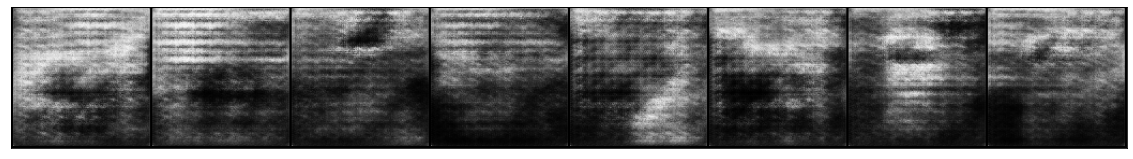

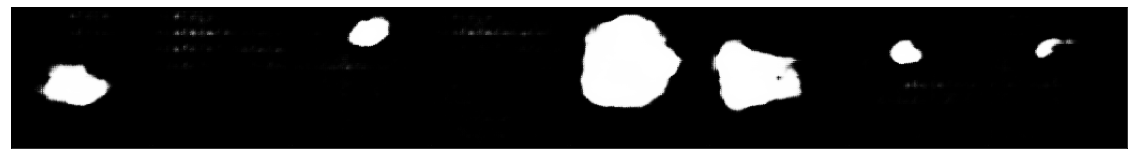

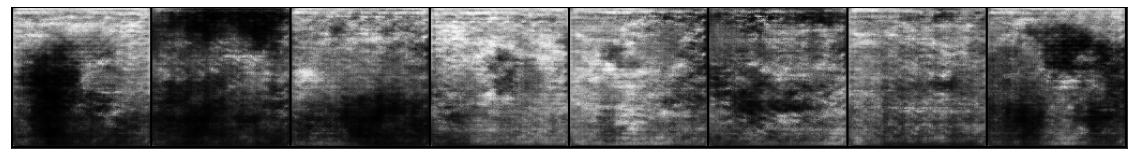

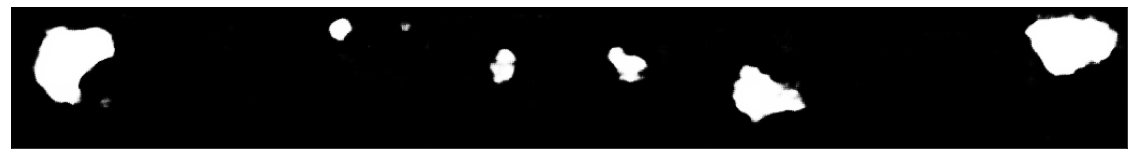

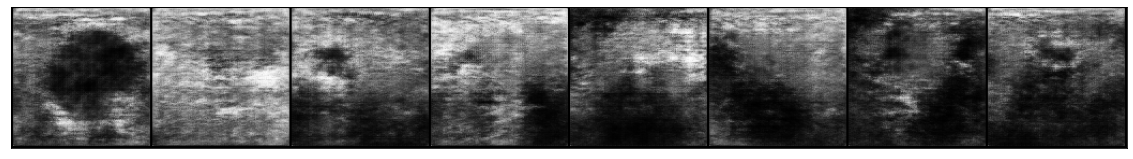

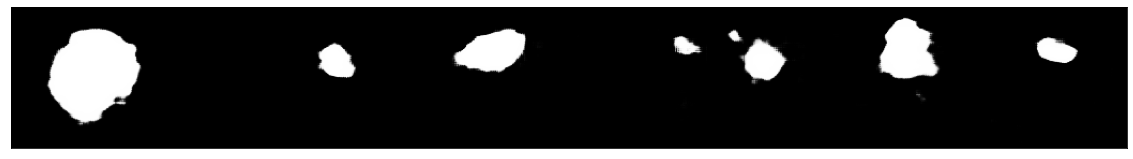

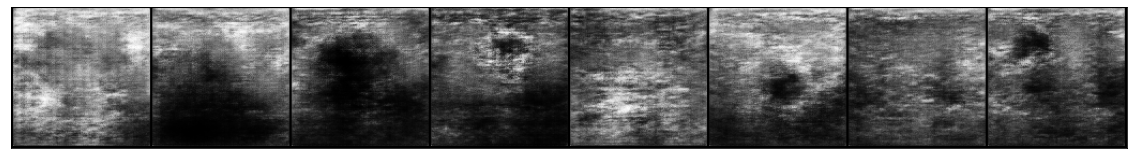

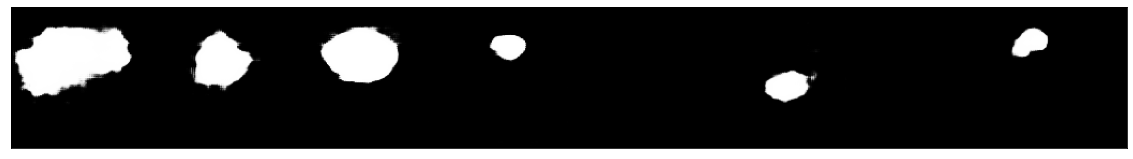

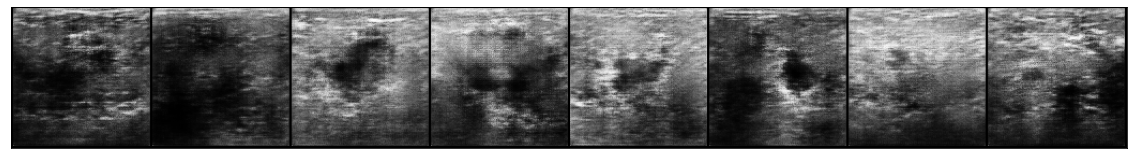

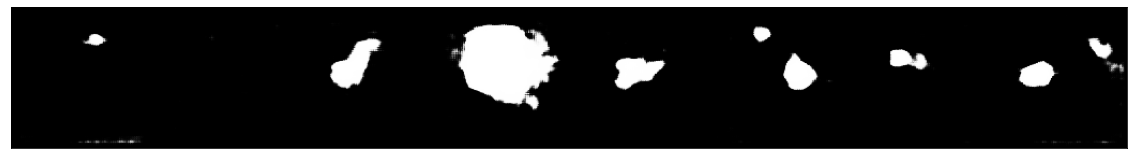

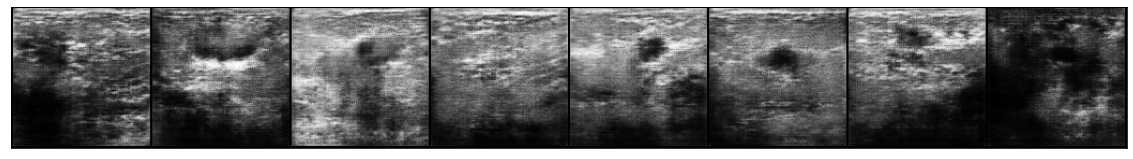

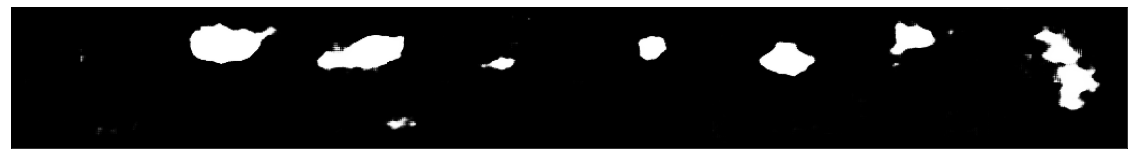

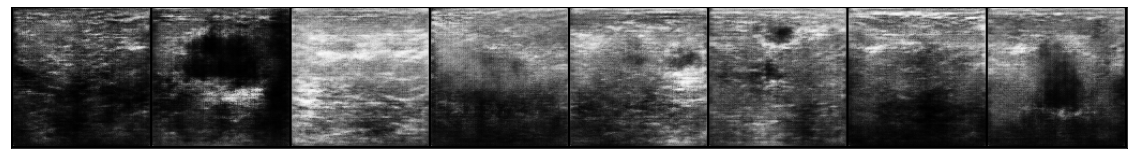

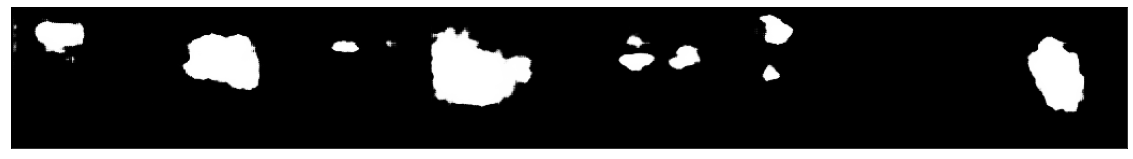

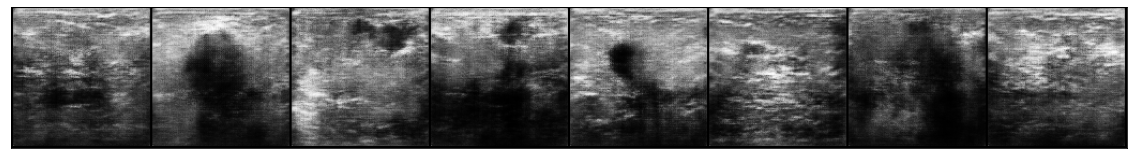

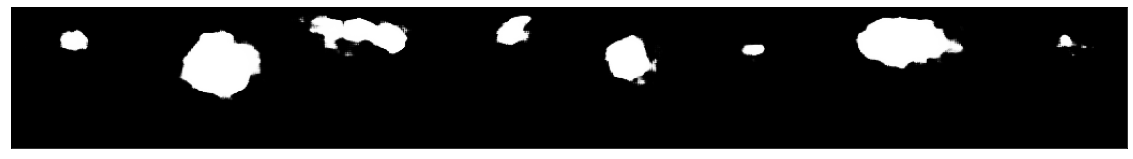

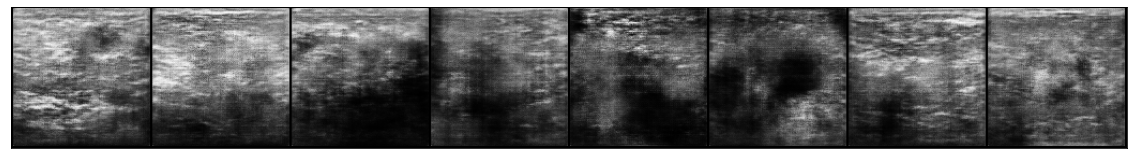

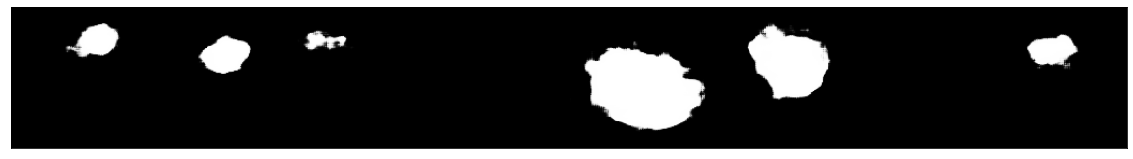

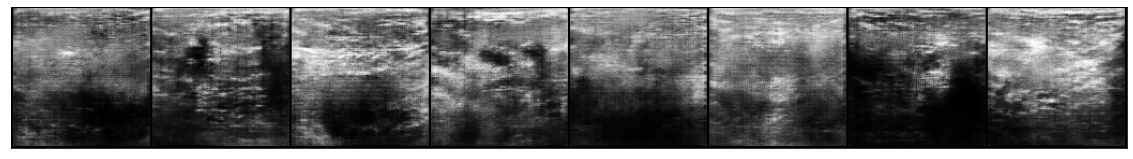

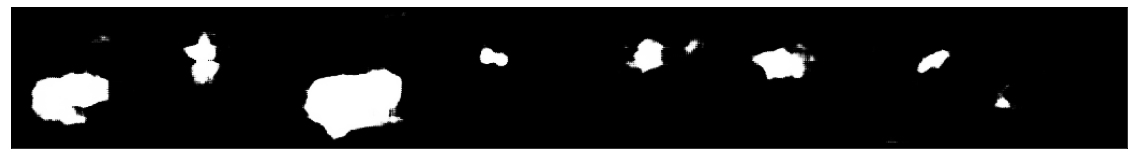

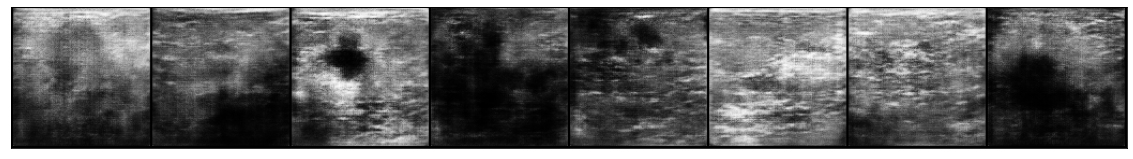

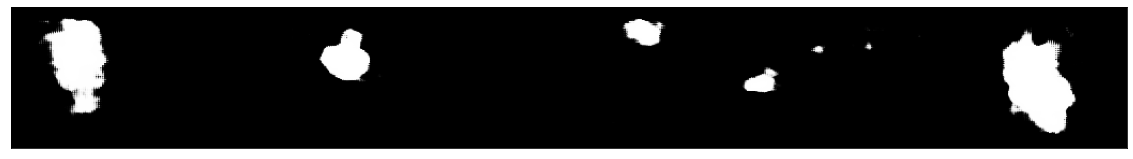

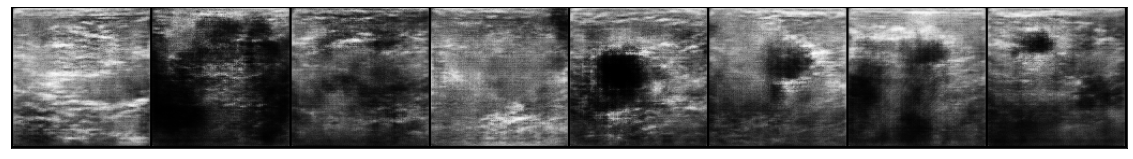

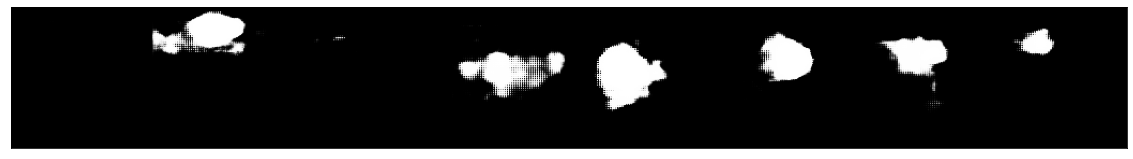

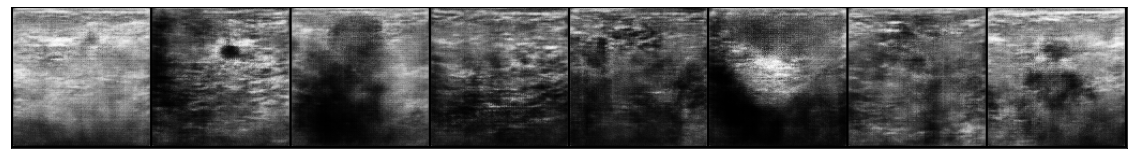

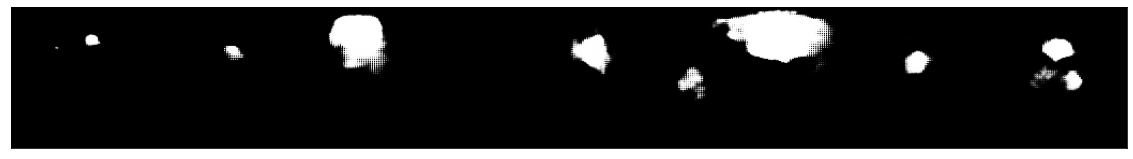

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nz = 100
GNet = Generator(nz, 1024, 2).to(device)
GNet.apply(weights_init)
DNet = Discriminator(2, 32).to(device)
DNet.apply(weights_init)

optimizerG = optim.Adam(GNet.parameters(), lr=0.0001, betas=(0,0.9))
optimizerD = optim.Adam(DNet.parameters(), lr=0.0001, betas=(0,0.9))

criterion = WassersteinLoss()

real_label = -1
fake_label = 1

cr_iter_per_gen_iter = 5
#clip_limit = 0.5
lambda_gp = 10

disc_loss = []
gen_loss = []
num_epochs = 700

for e in range(num_epochs):
    dLossFake = 0
    dLossReal = 0
    dLoss = 0
    gLoss = 0
    
    for i, (image, mask, imgLabel) in enumerate(dataLoader, 1):
        image = torch.squeeze(image)
        mask = torch.squeeze(mask)
        imgLabel = imgLabel.to(device)
        
        B, H, W = image.shape
        real_input = torch.stack((image, mask)).permute(1,0,2,3).to(device)
        label = torch.full((B,), real_label, dtype=torch.float, device=device)
        
        DNet.zero_grad()
            
        sOutput = DNet(real_input).view(-1)
        dLoss_real = criterion(sOutput, label)
        
        dLoss_real.backward()
        
        noise = torch.randn(B, nz, 1, 1, device=device)
        noisyLabel = torch.randint(0, 3, (B,), device=device)
        fake_input = GNet(noise)
        label.fill_(fake_label)
        
        sOutput = DNet(fake_input.detach()).view(-1)
        dLoss_fake = criterion(sOutput, label)
        
        dLoss_fake.backward()
        
        gradient_penalty = lambda_gp * compute_gradient_penalty(DNet, real_input, fake_input.detach(), device)
        gradient_penalty.backward()
        
        optimizerD.step()
        
        """"for p in DNet.parameters():
            p.data.clamp_(-clip_limit, clip_limit)"""
        
        dLossReal += dLoss_real 
        dLossFake += dLoss_fake
        
        dLoss = dLossFake - dLossReal
        
        if i % cr_iter_per_gen_iter == 0:
            GNet.zero_grad()
            label.fill_(real_label)

            sOutput = DNet(fake_input).view(-1)
            gLoss_ = criterion(sOutput, label)
            gLoss_.backward()

            optimizerG.step()
        
            gLoss += gLoss_
    
    if (e+1)%50 == 0:
        generate_samples(GNet, device)
        
    disc_loss.append(dLoss.item())
    gen_loss.append(gLoss.item())
    if (e+1)%5 == 0:
        print('Epoch {:.0f}/{:.0f} : Discriminator real loss: {:.4f} | Discriminator fake loss: {:.4f} | Discriminator loss: {:.4f} | Generator loss: {:.4f}'.format(e+1, num_epochs, dLossReal, dLossFake, dLoss, gLoss))

Text(0, 0.5, 'Critic Score')

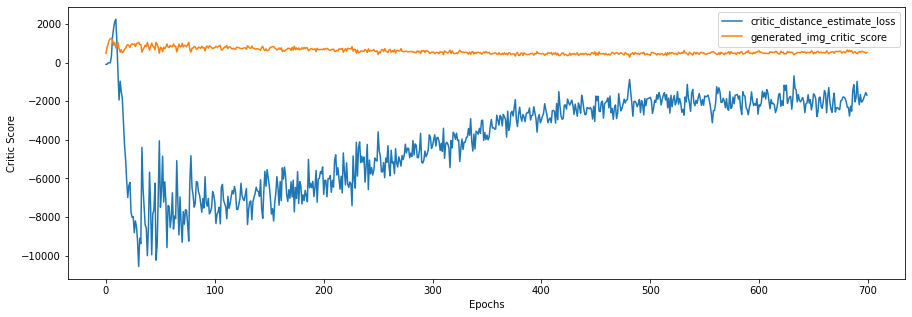

In [15]:
fig = plt.figure(figsize=[15,5])
plt.plot(range(num_epochs), disc_loss, label='critic_distance_estimate_loss')
plt.plot(range(num_epochs), gen_loss, label='generated_img_critic_score')

plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Critic Score')

In [16]:
def enable_dropout(m):
    for each_module in m.modules():
        if each_module.__class__.__name__.startswith('Dropout'):
            each_module.train()

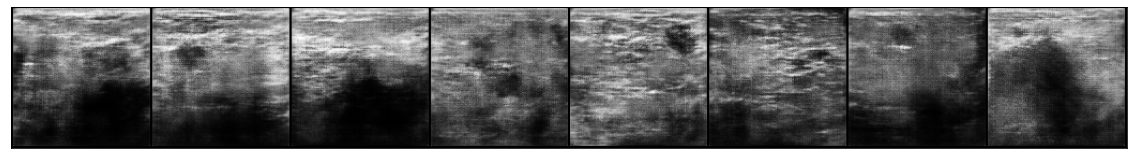

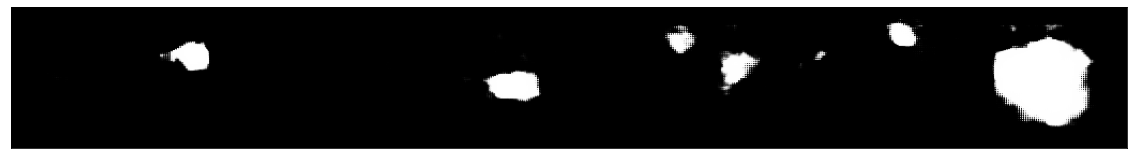

In [17]:
generate_samples(GNet, device)